# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    
    in_channels = 1
    out_channels = 6
    kernel_size = 5
    self.input_image_size1 = (28, 28)
    self.image_output_size1 = (24, 24)
    # TODO
    self.fc1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
    
    in_channels = 6
    out_channels = 16
    kernel_size = 5
    self.input_image_size2 = (12, 12)
    self.image_output_size2 = (8, 8)
    # TODO
    self.fc2 = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
    
    input_dim = 256 #( H x W x C)
    output_dim = 120
    # TODO
    self.fc3 = torch.nn.Linear(input_dim, output_dim)
    
    input_dim = 120
    output_dim = 84
    # TODO
    self.fc4 = torch.nn.Linear(input_dim, output_dim)
    
    
    input_dim = 84
    output_dim = 10
    # TODO
    self.fc5 = torch.nn.Linear(input_dim, output_dim)
    
    
  def forward(self, x):
    
    # TODO
    # Max Pooling with 
    kernel_size = 2
    # output size = (14,14)
    x = F.max_pool2d( self.fc1(x) ,kernel_size)
    
    # TODO
    #Max pooling with
    kernel_size = 2
    # output size = (5,5)
    x = F.max_pool2d( self.fc2(x),kernel_size)
    
    # flatten the feature maps into a long vector#...
    x = x.view(x.shape[0], -1)
    
    # TODO
    x = F.relu(self.fc3(x))
    
    # TODO
    x = F.relu(self.fc4(x))
    
    # TODO
    x = F.softmax(self.fc5(x), dim=1)
    
    return x

### Define cost function

In [3]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum 

In [4]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr=lr, weight_decay = wd, momentum=momentum)
  return optimizer

### Train and test functions

In [5]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer
      
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***? 

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\]. 

***How it can be done***? 

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [6]:
def get_data(batch_size, test_batch_size=256):
  
  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True) 
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True) 
  

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [7]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, net = LeNet()):
  
  train_loader, val_loader, test_loader = get_data(batch_size)
  
  # TODO for defining LeNet-5 
  net = net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net

Lets train!

In [8]:
net = main(epochs=20)

100%|██████████| 9912422/9912422 [00:00<00:00, 104680415.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122235816.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38112064.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4989661.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Before training:
	 Training loss 0.01804, Training accuracy 8.85
	 Validation loss 0.00906, Validation accuracy 9.59
	 Test loss 0.00921, Test accuracy 9.48
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01801, Training accuracy 31.05
	 Validation loss 0.00902, Validation accuracy 45.29
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01610, Training accuracy 49.36
	 Validation loss 0.00679, Validation accuracy 74.20
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01311, Training accuracy 79.51
	 Validation loss 0.00630, Validation accuracy 87.34
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01217, Training accuracy 91.55
	 Validation loss 0.00604, Validation accuracy 93.20
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01197, Training accuracy 93

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mat = torch.zeros((10,10))
train_loader, val_loader, test_loader = get_data(batch_size=128)
for batch_idx, (inputs, targets) in enumerate(test_loader):
  inputs = inputs.to('cuda:0')
  targets = targets.to('cuda:0')
    
  outputs = torch.argmax(net(inputs), dim=1)

  mat += confusion_matrix(outputs.detach().cpu(), targets.detach().cpu())

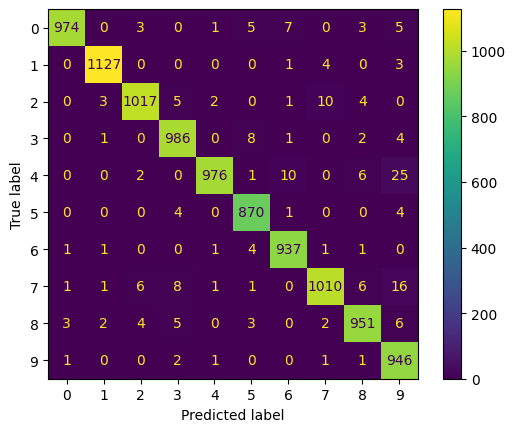

In [10]:
import matplotlib.pyplot as plt

mat = mat.detach().numpy().astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.show()

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [11]:
LeNet5 = torch.nn.Sequential(
          torch.nn.Conv2d(1,6,5),
          torch.nn.MaxPool2d(2),
          torch.nn.Conv2d(6,16,5),
          torch.nn.MaxPool2d(2),
          torch.nn.Flatten(),
          torch.nn.Linear(256,120),
          torch.nn.ReLU(),
          torch.nn.Linear(120,84),
          torch.nn.ReLU(),
          torch.nn.Linear(84,10),
          torch.nn.Softmax(dim=1),
        )

In [12]:
LeNet5 = main(epochs=20, net= LeNet5)

Before training:
	 Training loss 0.01804, Training accuracy 12.98
	 Validation loss 0.00906, Validation accuracy 13.13
	 Test loss 0.00921, Test accuracy 13.06
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01801, Training accuracy 19.00
	 Validation loss 0.00901, Validation accuracy 20.53
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01577, Training accuracy 47.33
	 Validation loss 0.00672, Validation accuracy 76.84
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01297, Training accuracy 81.34
	 Validation loss 0.00641, Validation accuracy 83.54
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01271, Training accuracy 84.16
	 Validation loss 0.00635, Validation accuracy 84.87
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01261, Training accuracy 85.39
	 Validation loss 0.00630, Validation accuracy 86.13
---------------

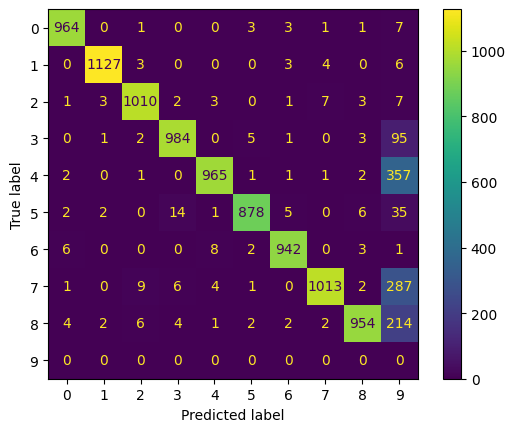

In [13]:

mat = torch.zeros((10,10))
train_loader, val_loader, test_loader = get_data(batch_size=128)
for batch_idx, (inputs, targets) in enumerate(test_loader):
  inputs = inputs.to('cuda:0')
  targets = targets.to('cuda:0')
    
  outputs = torch.argmax(LeNet5(inputs), dim=1)

  mat += confusion_matrix(outputs.detach().cpu(), targets.detach().cpu())


mat = mat.detach().numpy().astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.show()

##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset. 
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.





CIFAR dataset + we implement the data augmentation there : 

In [41]:
def get_data_cifar(batch_size=4, test_batch_size=256, augmentation=False, Notresnet=True):
  
  # Prepare data transformations and then combine them sequentially
  transform = list()

  ################      DATA AUGMENTATION   ##################
  if augmentation : 
    transform.append(T.RandomHorizontalFlip(p=0.5))
    transform.append(T.RandomVerticalFlip(p=0.5))
                    #######################

  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]

  if Notresnet : 
    transform.append(T.Lambda(lambda x: torch.reshape(x, (3, 32, 32))))
    transform.append(T.Lambda( lambda x : torch.mean(x, dim=0)))
    transform.append(T.CenterCrop((28,28)))
    transform.append(T.Lambda(lambda x: torch.reshape(x, (1, 28, 28))))

  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
  
  
  # Create train and validation splits
  num_samples = len(trainset)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(trainset, [training_samples, validation_samples])

  # Initialize dataloaders

  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(testset, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

Early Stopping:

In [42]:
import numpy as np

def main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, net = LeNet(), validation=0, cifar=False, augmentation=False, Notresnet=True):
  
  if cifar :
    train_loader, val_loader, test_loader = get_data_cifar(batch_size, augmentation=augmentation, Notresnet=Notresnet)
    

  else:
    train_loader, val_loader, test_loader = get_data(batch_size)
  
  # TODO for defining LeNet-5 
  net = net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  val_loss_old = 0
  k = 0
  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    
    #############   EARLY START #############
    while k != 0: 
      if np.abs(val_loss_old-val_loss) < 1e-5:
        k+=1
      else:
        k = 0
      val_loss_old = val_loss
    if (k==validation and k!=0):
      break
                  ##############
                  
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net

In [30]:
LeNet5 = main(epochs=20, net= LeNet5, validation = 5, cifar=True)

Files already downloaded and verified
Files already downloaded and verified
Before training:
	 Training loss 0.01839, Training accuracy 9.10
	 Validation loss 0.00920, Validation accuracy 8.75
	 Test loss 0.00939, Test accuracy 8.83
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01780, Training accuracy 17.49
	 Validation loss 0.00873, Validation accuracy 21.98
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01730, Training accuracy 24.24
	 Validation loss 0.00858, Validation accuracy 26.15
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01703, Training accuracy 28.04
	 Validation loss 0.00849, Validation accuracy 28.66
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01684, Training accuracy 30.73
	 Validation loss 0.00840, Validation accuracy 31.03
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01665, Training accuracy 3

Files already downloaded and verified
Files already downloaded and verified


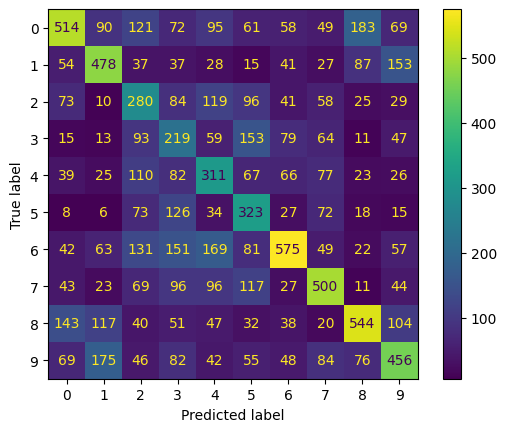

In [47]:

mat = torch.zeros((10,10))
train_loader, val_loader, test_loader = get_data_cifar(batch_size=128)
for batch_idx, (inputs, targets) in enumerate(test_loader):
  inputs = inputs.to('cuda:0')
  targets = targets.to('cuda:0')
    
  outputs = torch.argmax(LeNet5(inputs), dim=1)

  mat += confusion_matrix(outputs.detach().cpu(), targets.detach().cpu())


mat = mat.detach().numpy().astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.show()

In [34]:
LeNet5_Dropout = torch.nn.Sequential(
          torch.nn.Conv2d(1,6,5),
          torch.nn.MaxPool2d(2),
          torch.nn.Conv2d(6,16,5),
          torch.nn.MaxPool2d(2),
          torch.nn.Flatten(),
          torch.nn.Linear(256,120),
          torch.nn.Dropout(p=0.5),
          torch.nn.ReLU(),
          torch.nn.Linear(120,84),
          torch.nn.Dropout(p=0.5),
          torch.nn.ReLU(),
          torch.nn.Linear(84,10),
          torch.nn.Softmax(dim=1),
        )

In [35]:
LeNet5_Dropout = main(epochs=20, net= LeNet5_Dropout, validation = 5, cifar=True, augmentation=True)

Files already downloaded and verified
Files already downloaded and verified
Before training:
	 Training loss 0.01805, Training accuracy 9.78
	 Validation loss 0.00903, Validation accuracy 9.97
	 Test loss 0.00921, Test accuracy 9.93
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01805, Training accuracy 10.57
	 Validation loss 0.00903, Validation accuracy 13.02
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01805, Training accuracy 11.76
	 Validation loss 0.00902, Validation accuracy 13.60
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01804, Training accuracy 12.88
	 Validation loss 0.00902, Validation accuracy 13.52
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01802, Training accuracy 13.88
	 Validation loss 0.00899, Validation accuracy 15.15
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01793, Training accuracy 1

In [49]:
mat = torch.zeros((10,10))
train_loader, val_loader, test_loader = get_data_cifar(batch_size=128)
for batch_idx, (inputs, targets) in enumerate(test_loader):
  inputs = inputs.to('cuda:0')
  targets = targets.to('cuda:0')
    
  outputs = torch.argmax(LeNet5_Dropout(inputs), dim=1)

  mat += confusion_matrix(outputs.detach().cpu(), targets.detach().cpu())


mat = mat.detach().numpy().astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


ValueError: ignored

Here applying the dropout and the data augmentation does not seem to improve the results, but it might be because of the low number of epochs. 

In [38]:
from torchvision.models import resnet18

resnet18 = resnet18(pretrained=True)

resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 260MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 10),
    torch.nn.Softmax(dim=1)) #To have the right number of features + a softmax at the end

resnet18 = main(epochs=20, net= resnet18, validation = 5, cifar=True, Notresnet=False)

Files already downloaded and verified
Files already downloaded and verified
Before training:
	 Training loss 0.01804, Training accuracy 10.84
	 Validation loss 0.00902, Validation accuracy 10.60
	 Test loss 0.00921, Test accuracy 10.98
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01496, Training accuracy 55.85
	 Validation loss 0.00694, Validation accuracy 69.13
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01358, Training accuracy 72.93
	 Validation loss 0.00684, Validation accuracy 71.60
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01331, Training accuracy 76.35
	 Validation loss 0.00679, Validation accuracy 72.69
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01310, Training accuracy 79.05
	 Validation loss 0.00674, Validation accuracy 74.15
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01297, Training accurac